In [2]:
!unzip 3D_mnist.zip

Archive:  3D_mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv3D, BatchNormalization, MaxPooling3D

In [4]:
with h5py.File('full_dataset_vectors.h5', 'r') as dataset:
    X_train = dataset["X_train"][:]
    X_test  = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test  = dataset["y_test"][:]
    
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

X_train shape: (10000, 4096), X_test shape: (2000, 4096)


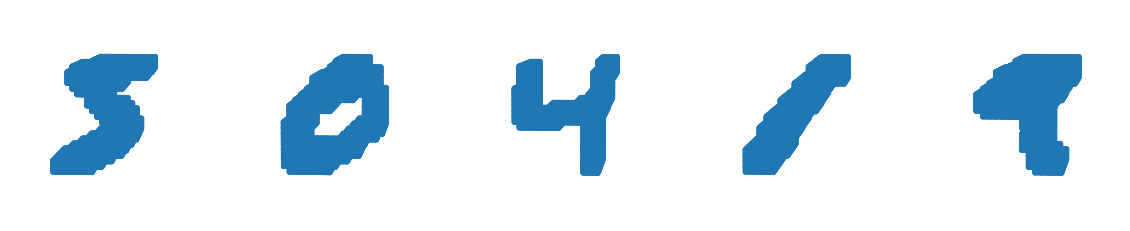

In [6]:
with h5py.File('train_point_clouds.h5', 'r') as hf:
    n_rows, n_cols = 1, 5
    fig = plt.figure(figsize=(20, 4))
    
    for i in range(n_cols):
        a = hf[str(i)]
        digit = (a["img"][:], a["points"][:], a.attrs["label"]) 
        ax = fig.add_subplot(1, n_cols, i+1, projection='3d')
    
        X = a["points"][:][:,0]
        Y = a["points"][:][:,1]
        Z = a["points"][:][:,2]

        ax.scatter(X, Y, Z)
        ax.view_init(5, 5)
        ax.axis('off')

### Reshape to 3D images

In [7]:
X_train_shaped = np.ndarray((X_train.shape[0], 4096, 3))
X_test_shaped  = np.ndarray((X_test.shape[0], 4096, 3))

def array_to_color(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(X_train_shaped.shape[0]):
    X_train_shaped[i] = array_to_color(X_train[i])
    
for i in range(X_test_shaped.shape[0]):
    X_test_shaped[i] = array_to_color(X_test[i])

X_train = np.reshape(X_train_shaped, (X_train_shaped.shape[0], 16, 16, 16, 3))
X_test  = np.reshape(X_test_shaped, (X_test_shaped.shape[0], 16, 16, 16, 3))
    
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

X_train shape: (10000, 16, 16, 16, 3), X_test shape: (2000, 16, 16, 16, 3)


In [8]:
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

y_train shape: (10000, 10), y_test shape: (2000, 10)


In [9]:
def my_model():
    # create the CNN model
    model = Sequential([
        Conv3D(16, (3,3,3), activation='relu', padding='same', input_shape=(16, 16, 16, 3)),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2), strides=2),
        Conv3D(32, (3,3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2), strides=2),
        Conv3D(128, (3,3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2), strides=2),
        Flatten(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ], name='3D_mnist_model')
    return model

In [10]:
model = my_model()
model.summary()

Model: "3D_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 16, 16, 16)    1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 8, 8, 16)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 8, 8, 32)       13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 8, 32)       128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 4, 4, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 128)   

In [11]:
# compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
# fit the parameters
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100)

Epoch 1/100
157/157 [==============================] - 3s 20ms/step - loss: 2.2328 - accuracy: 0.1851
Epoch 2/100
157/157 [==============================] - 3s 19ms/step - loss: 1.5710 - accuracy: 0.4489
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 1.2738 - accuracy: 0.5580
Epoch 4/100
157/157 [==============================] - 3s 19ms/step - loss: 1.1488 - accuracy: 0.6011
Epoch 5/100
157/157 [==============================] - 3s 19ms/step - loss: 1.0722 - accuracy: 0.6283
Epoch 6/100
157/157 [==============================] - 3s 19ms/step - loss: 1.0137 - accuracy: 0.6464
Epoch 7/100
157/157 [==============================] - 3s 19ms/step - loss: 0.9457 - accuracy: 0.6665
Epoch 8/100
157/157 [==============================] - 3s 20ms/step - loss: 0.9040 - accuracy: 0.6839
Epoch 9/100
157/157 [==============================] - 3s 19ms/step - loss: 0.8678 - accuracy: 0.6990
Epoch 10/100
157/157 [==============================] - 3s 20ms/step - loss: 0.814

Training accuracy after 100 epochs: 0.9823
Training loss after 100 epochs: 0.0579


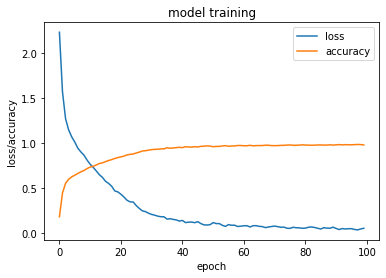

In [15]:
print('Training accuracy after 100 epochs: %.4f'%history.history['accuracy'][-1])
print('Training loss after 100 epochs: %.4f'%history.history['loss'][-1])
# plot the accuracy and loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model training')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

In [16]:
print('Let us evaluate our model on the test set')
mse, acc = model.evaluate(X_test, y_test)
print('mean_squared_error :', mse)
print('accuracy:', acc)

Let us evaluate our model on the test set
63/63 [==============================] - 0s 5ms/step - loss: 1.5555 - accuracy: 0.7345
mean_squared_error : 1.555484652519226
accuracy: 0.734499990940094


### We can see that the model performs well on the training set, but it does not do as well on the test set. A better regularized architecture is necessary to do well on both. Moreover, collecting more data and creating a validation set that is from the same distribution as the test set would be helpful to fine tune the parameters of the model before testing it.